In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re, string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk, subprocess

import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rbaud\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [3]:
df = pd.read_csv('emotions.csv')
df

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [5]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
df.duplicated().sum()

686

In [7]:
df = df.drop_duplicates()
df

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


In [9]:
sentences = df['text']
labels = df['label']

In [13]:
lemmatizer = WordNetLemmatizer()

In [21]:
stop_words = set(stopwords.words("english"))

def transform_data(review):
    review = review.lower()
    review = re.sub("^a-zA-Z0-9", ' ', review)
    review = re.sub('<.*?>', ' ', review)
    review = "".join([x for x in review if x not in string.punctuation])
    review = review.split()
    review = [lemmatizer.lemmatize(x) for x in review if x not in stop_words]
    review = " ".join(review)
    return review

sentences = sentences.apply(transform_data)

In [23]:
sentences[:5]

0                   feel really helpless heavy hearted
1    ive enjoyed able slouch relax unwind frankly n...
2              gave internship dmrg feeling distraught
3                                  dont know feel lost
4    kindergarten teacher thoroughly weary job take...
Name: text, dtype: object

### Data Visualization

In [25]:
word_counts =[]

word_count = [word_counts.append(len(sentence.split(" "))) for sentence in sentences]

In [26]:
max(word_counts)

79

In [27]:
df['label'].value_counts()

label
1    140779
0    120989
3     57235
4     47664
2     34497
5     14959
Name: count, dtype: int64

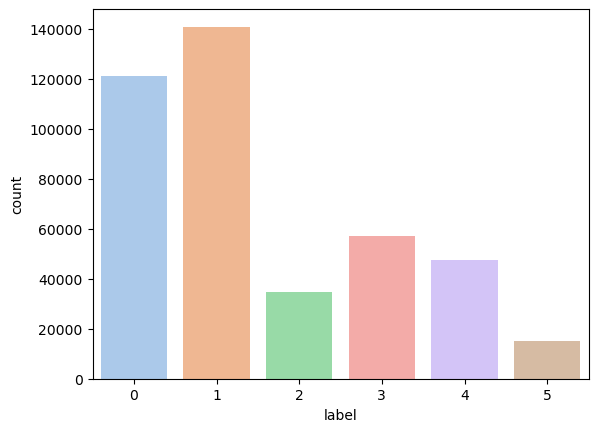

In [31]:
sns.countplot(data=df, x='label', palette='pastel')
plt.show()

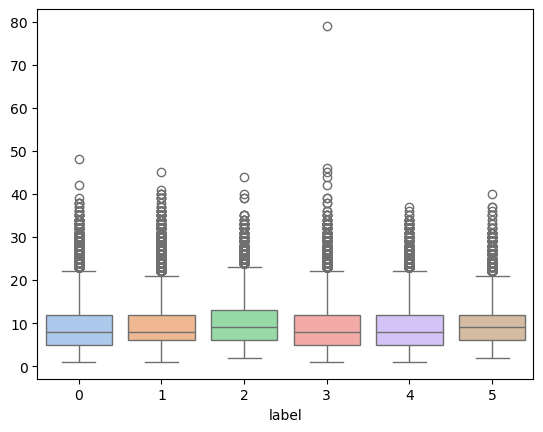

In [33]:
sns.boxplot(y=word_counts, x='label', data=df, palette='pastel')  # Change 'pastel' to any palette you prefer
plt.show()

### Data Preprocessing

In [34]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

In [36]:
vocab_size = 10000
onehot_rep = [one_hot(word, vocab_size) for word in sentences]

In [37]:
print(sentences[0])
print(onehot_rep[0])

feel really helpless heavy hearted
[4881, 8246, 4285, 7615, 7064]


In [38]:
max_len = 50
embedding_docs = pad_sequences(
    sequences=onehot_rep,
    padding = 'post',
    maxlen=max_len
)

In [39]:
embedding_docs.shape

(416123, 50)

### 
-Original sentence, one hot representation and embedding docs

In [41]:
print(sentences[0])
print(onehot_rep[0])
print(embedding_docs[0])

feel really helpless heavy hearted
[4881, 8246, 4285, 7615, 7064]
[4881 8246 4285 7615 7064    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embedding_docs, 
    labels, 
    train_size=0.8, 
    random_state=42
)

In [43]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(332898, 50) (332898,) (83225, 50) (83225,)


In [44]:
# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(X_train)
testing_labels_final = np.array(y_train)

### Create the model using an Embedding

In [45]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Dense, LSTM, SpatialDropout1D

In [47]:
embedding_dim = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=embedding_docs.shape[1]))
model.add(Bidirectional(LSTM(embedding_dim,return_sequences=True)))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           1280000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 256)           263168    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 6)                 1542      
                                                                 
 dense_3 (Dense)             (None, 6)                 42        
                                                                 
Total params: 1938992 (7.40 MB)
Trainable params: 1938

### Train the model

In [49]:
from keras.optimizers import Adam

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = Adam(),
    metrics=['accuracy']
)

In [50]:
from keras.callbacks import EarlyStopping

history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=512,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)]
)

Epoch 1/10


521/521 [==============================] - 530s 1s/step - loss: 0.6672 - accuracy: 0.7501 - val_loss: 0.2299 - val_accuracy: 0.9039
Epoch 2/10
521/521 [==============================] - 496s 952ms/step - loss: 0.1804 - accuracy: 0.9150 - val_loss: 0.1662 - val_accuracy: 0.9164
Epoch 3/10
521/521 [==============================] - 428s 822ms/step - loss: 0.1430 - accuracy: 0.9246 - val_loss: 0.1626 - val_accuracy: 0.9199
Epoch 4/10
521/521 [==============================] - 409s 786ms/step - loss: 0.1287 - accuracy: 0.9292 - val_loss: 0.1561 - val_accuracy: 0.9188
Epoch 5/10
521/521 [==============================] - 408s 782ms/step - loss: 0.1202 - accuracy: 0.9311 - val_loss: 0.1572 - val_accuracy: 0.9223
Epoch 6/10
521/521 [==============================] - 405s 778ms/step - loss: 0.1137 - accuracy: 0.9339 - val_loss: 0.1640 - val_accuracy: 0.9193
Epoch 7/10
521/521 [==============================] - 407s 781ms/step - loss: 0.1079 - accuracy: 0.9364 - val_loss: 0.1612 - 

C:\Users\rbaud\AppData\Local\Temp\ipykernel_17256\152922821.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=history.history[string], palette='pastel')
C:\Users\rbaud\AppData\Local\Temp\ipykernel_17256\152922821.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=history.history['val_'+string], palette='pastel')


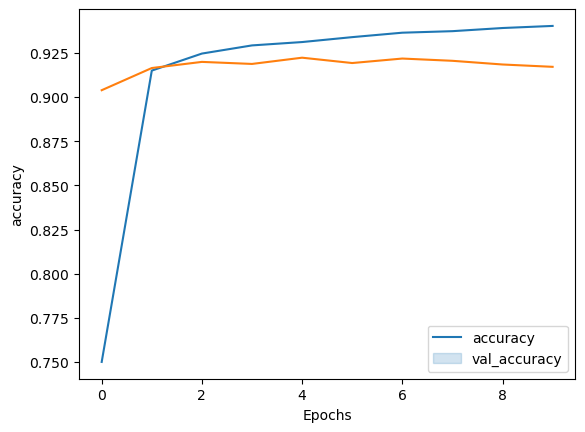

C:\Users\rbaud\AppData\Local\Temp\ipykernel_17256\152922821.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=history.history[string], palette='pastel')
C:\Users\rbaud\AppData\Local\Temp\ipykernel_17256\152922821.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=history.history['val_'+string], palette='pastel')


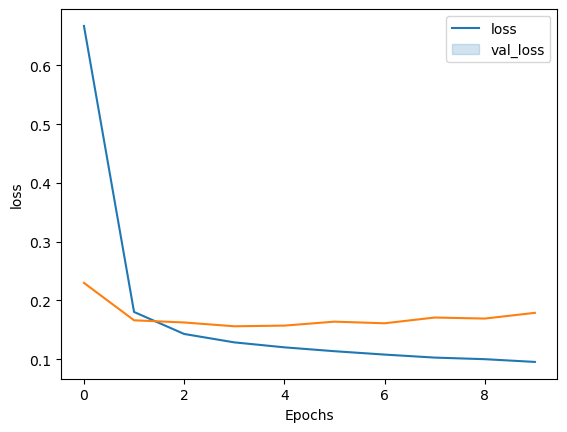

In [51]:
def plot_graphs(history, string):
    sns.lineplot(data=history.history[string], palette='pastel')
    sns.lineplot(data=history.history['val_'+string], palette='pastel')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Test the model

In [52]:
def predict_emotions(model, new_sentences, maxlen=max_len, show_padded_sequence=True ):
    new_sequences = []
    
    for word in sentences:
        new_sequences.append(one_hot(word, 1000))
    
    trunc_type='pre' 
    padding_type='pre'

    # Pad all sequences for the new reviews
    new_emotion_padded = pad_sequences(new_sequences, maxlen=max_len, 
                                 padding=padding_type, truncating=trunc_type)             
    
    classes = model.predict([new_emotion_padded])

  # The closer the class is to 1, the more positive the review is
    for x in range(len(new_sentences)):
        if (show_padded_sequence):
            print(new_emotion_padded[x])
        
        print(new_sentences[x])
        print(classes[x])
        print("\n")

In [53]:
# Use the model to predict some reviews   
emotions = ["I just feel really helpless and heavy hearted"]

predict_emotions(model, emotions)

13004/13004 [==============================] - 355s 27ms/step
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 102 713 739 460  98]
I just feel really helpless and heavy hearted
[1.1711928e-01 4.5755479e-02 3.0636965e-04 6.9128144e-01 1.3905771e-01
 6.4797709e-03]


